In [108]:
class Node:
    def __init__(self, data, depth=0, lchild=None, rchild=None):
        self.data = data
        self.depth = depth
        self.lchild = lchild
        self.rchild = rchild


class KdTree:
    def __init__(self):
        self.KdTree = None
        self.n = 0
        self.nearest = None

    def create(self, dataSet, depth=0):
        if len(dataSet) > 0:
            m, n = np.shape(dataSet)
            self.n = n - 1
            axis = depth % self.n
            mid = int(m / 2)
            dataSetcopy = sorted(dataSet, key=lambda x: x[axis])
            node = Node(dataSetcopy[mid], depth)
            if depth == 0:
                self.KdTree = node
            node.lchild = self.create(dataSetcopy[:mid], depth+1)
            node.rchild = self.create(dataSetcopy[mid+1:], depth+1)
            return node
        return None

    def preOrder(self, node):
        if node is not None:
            print(node.depth, node.data)
            self.preOrder(node.lchild)
            self.preOrder(node.rchild)

    def search(self, x, count=1):
        nearest = []
        for i in range(count):
            nearest.append([-1, None])
        self.nearest = np.array(nearest)

        def recurve(node):
            if node is not None:
                axis = node.depth % self.n
                daxis = x[axis] - node.data[axis]
                if daxis < 0:
                    recurve(node.lchild)
                else:
                    recurve(node.rchild)

                dist = sqrt(sum((p1 - p2) ** 2 for p1, p2 in zip(x, node.data)))
                for i, d in enumerate(self.nearest):
                    if d[0] < 0 or dist < d[0]:
                        self.nearest = np.insert(self.nearest, i, [dist, node], axis=0)
                        self.nearest = self.nearest[:-1]
                        break

                n = list(self.nearest[:, 0]).count(-1)
                if self.nearest[-n-1, 0] > abs(daxis):
                    if daxis < 0:
                        recurve(node.rchild)
                    else:
                        recurve(node.lchild)

        recurve(self.KdTree)

        knn = self.nearest[:, 1]
        belong = []
        for i in knn:
            belong.append(i.data[-1])
        b = max(set(belong), key=belong.count)

        return self.nearest, b

In [109]:
%%time
import numpy as np
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
min_max_scaler=preprocessing.MinMaxScaler()

def run(df):
    rate=0.4
    noise_set=pd.DataFrame(columns=df.columns)
    for r in range(0,(df.label.max()+1)):    
        noise_set=pd.concat([noise_set,df[df.label==r].sample(frac=rate, replace=False)]) #选取噪声比例  
    #bb=df[df.label==1].sample(frac=rate, replace=False) #选取噪声比例
    #cc=df[df.label==2].sample(frac=rate, replace=False) #选取噪声比例
 
    data_cut=df[~df.index.isin(noise_set.index)]
    no=[]
    for j in range(0,len(noise_set)):
        no.append(int(np.random.rand(1)[0]*(df.label.max()+1))%10)
    noise_set['label2']=no
    noise_set.reset_index(drop=True,inplace=True)
    for l in range(0,len(noise_set)):  #随机替换标签
        if (noise_set.loc[l,'label']==noise_set.loc[l,'label2']):
            noise_set.loc[l,'label2']=(noise_set.loc[l,'label']+1) % (df.label.max()+1)
    noise=noise_set.drop(['label'],axis=1)
    noise.rename(columns={'label2':'label'}, inplace = True)
    data= pd.concat([data_cut,noise],axis=0,ignore_index=True) #含噪声数据集

    data=np.array(data)
    kdt = KdTree()
    kdt.create(data)
    # kdt.preOrder(kdt.KdTree)

    dist2=[]
    data2=np.array(df.drop('label',axis=1))
    for m in range(0,len(data2)-1):
        for n in range(m+1,len(data2)):
             dist2.append(sqrt(sum((data2[m] - data2[n]) ** 2 )))
    F1 = []
    a = np.percentile(dist2,10) #密度阈值(%10分位数)
    
    x1 = np.array([[1,1],[1,-1]])
    x2 = np.array([1,np.floor(7 / 3)/ 7])
    (Ps_,Pd_)=np.linalg.solve(x1,x2)
    H_ = -Ps_* np.log2(Ps_)-Pd_*np.log2(Pd_) #标签混合程度阈值
    
    for relative_density in (np.arange(1,3.1,0.1)): #相对密度寻优
     #   print('相对密度阈值:',relative_density)
        Dn = []
        for x in data:
            #plt.scatter(x[0], x[1], c='red', marker='x')  # 测试点
            near, belong = kdt.search(x[:-1], 8)  # 设置临近点的个数
            #print("test:")
           # print(x, "predict:", belong)
           # print("nearest:")
            density = 0
            t,hon,hen,DRL = 0,0,0,0
            for n in near:
                density += n[0]  #密度
                if (x[-1] == n[1].data[-1])and(x != n[1].data).any():
                    t += 1
                    hon += 1
                elif x[-1] != n[1].data[-1]:
                    hen += 1
            DRL = (hen - hon) / 7 #标签异同差比
            Ps = t / 7
            Pd = 1 - Ps
            if (Ps==1)|(Ps==0):
                H = 0
            else:
                H = -Ps* np.log2(Ps)-Pd*np.log2(Pd)

           # print(densit)
            if (density <= a): #高密度区域
                if DRL > 0:
                    Dn.append(list(x))

                    #print('高密度区域噪声')
            else:
                if (H <= H_): #低密度单一标签区域
                    if DRL > 0:
                        Dn.append(list(x))
                           # print('低密度单一区域噪声')
                else: #低密度混合标签区域
                    data_hon,data_hen=[],[]
                    for i in data:
                        if i[-1]==x[-1]:
                            data_hon.append(i)
                        else:
                            data_hen.append(i)
                    data_prositive=np.array(data_hon)
                    data_negetive=np.array(data_hen)
                    kdt_hon=KdTree()
                    kdt_hen=KdTree()
                    kdt_hon.create(data_prositive)
                    kdt_hen.create(data_negetive)
                    near_hon,belong_hon=kdt_hon.search(x[:-1],8)
                    near_hen,belong_hen=kdt_hen.search(x[:-1],7)
                    dist_hon,dist_hen = 0,0
                    for n in near_hon:
                        dist_hon += n[0]
                       # print(n[1].data)
                    for n in near_hen:
                        dist_hen += n[0]
                       # print(n[1].data)
                    
                    if (dist_hon ) / (dist_hen ) >  relative_density:
                        Dn.append(list(x))
                       # print('低密度混合标签区域噪声')

        #print('标签噪声：',Dn)
        noise_list=noise.values.tolist()
        TP = 0
        for c in Dn:
            if c in noise_list:
                TP += 1
        FP = len(Dn) - TP
        FN = len(noise_list) - TP
        precision= TP / (TP + FP)
        recall= TP / (TP + FN)
        f1=2 * (precision * recall) / (precision + recall)
        F1.append(f1) #F1值
    return F1

Wall time: 0 ns


#鸢尾花数据集

In [110]:
%%time
from sklearn.datasets import load_iris
iris = load_iris()
iris_sample = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_sample = pd.DataFrame(min_max_scaler.fit_transform(np.array(iris_sample)))
iris_sample['label'] = iris.target
iris_sample= iris_sample.drop_duplicates()
iris_F1=run(iris_sample)

Wall time: 11.3 s


In [111]:
re_density_value[iris_F1.index(max(iris_F1))]

1.3000000000000003

#红酒数据集

In [112]:
%%time
from sklearn.datasets import load_wine
wine= load_wine()
wine_sample = pd.DataFrame(wine.data, columns=wine.feature_names)
wine_sample = pd.DataFrame(min_max_scaler.fit_transform(np.array(wine_sample)))
wine_sample['label'] = wine.target
wine_F1=run(wine_sample)

Wall time: 43.7 s


In [113]:
re_density_value[wine_F1.index(max(wine_F1))]

1.1

#种子数据集

In [114]:
%%time
seeds=pd.read_table('./mydata/Seed.txt',engine='python',names=['area','perimeter','compactness','length of kernel','width of kernel','asymmetry coefficient','length of kernel groove','label'])
seeds_sample=seeds[['area','perimeter','compactness','length of kernel','width of kernel','asymmetry coefficient','length of kernel groove']]
seeds_sample=pd.DataFrame(min_max_scaler.fit_transform(np.array(seeds_sample)))
seeds_sample['label']=seeds.label
seeds_F1=run(seeds_sample)

Wall time: 23.5 s


In [115]:
re_density_value[seeds_F1.index(max(seeds_F1))]

1.1

#避孕方法数据集

In [116]:
%%time
cmc=pd.read_table('./mydata/contraception.txt',sep=',',names=['wife_age','wife_edu','husband_edu','num_child','wife_religion','wife_work_station','husband_occupation','living_level','media_exposure','label'])
cmc.drop_duplicates(inplace=True)#删除重复数据
cmc_sample=cmc[['wife_age','wife_edu','husband_edu','num_child','wife_religion','wife_work_station','husband_occupation','living_level','media_exposure']]
cmc_sample=pd.DataFrame(min_max_scaler.fit_transform(np.array(cmc_sample)))
cmc_sample['label']=list(cmc.label-1) # 不加list标签会出错
cmc_F1=run(cmc_sample)

Wall time: 17min 51s


In [117]:
re_density_value[cmc_F1.index(max(cmc_F1))]

1.0

#汽车数据集

In [118]:
%%time
statlog=pd.read_csv('./mydata/statlog.csv',engine='python')
statlog.drop_duplicates(inplace=True)
statlog_sample=statlog[['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18']]
statlog_sample=pd.DataFrame(min_max_scaler.fit_transform(np.array(statlog_sample)))
statlog_sample['label']=statlog.label  
statlog_F1=run(statlog_sample)

Wall time: 12min 23s


In [119]:
re_density_value[statlog_F1.index(max(statlog_F1))]

1.3000000000000003

#蛋白质定位点数据集

In [120]:
%%time
ecoli=pd.read_csv('./mydata/ecoli.csv')
ecoli_F1=run(ecoli)

Wall time: 1min 6s


In [121]:
re_density_value[ecoli_F1.index(max(ecoli_F1))]

1.1

#玻璃数据集

In [122]:
%%time
glass=pd.read_csv('./mydata/glass.csv')
glass_sample=glass.drop(['label'],axis=1)
glass_sample=pd.DataFrame(min_max_scaler.fit_transform(np.array(glass_sample)))
glass_sample['label']=glass.label
glass_F1=run(glass_sample)

Wall time: 41.7 s


In [123]:
re_density_value[glass_F1.index(max(glass_F1))]

1.2000000000000002

#鲍鱼数据集

In [124]:
%%time
ablone=pd.read_csv('./mydata/ablone2.csv')
ablone_sample=ablone[['1','2','3','4','5','6','7','8']]
ablone_sample=pd.DataFrame(min_max_scaler.fit_transform(np.array(ablone_sample)))
ablone_sample['label']=ablone.label
ablone_F1=run(ablone)

Wall time: 23min 14s


In [125]:
re_density_value[ablone_F1.index(max(ablone_F1))]

1.0

#图像分割数据集

In [126]:
%%time
image=pd.read_csv('./mydata/image.csv')
image_sample=image.drop(['label'],axis=1)
image_sample=pd.DataFrame(min_max_scaler.fit_transform(np.array(image_sample)))
image_sample['label']=image.label
image_F1=run(image_sample)

Wall time: 47.8 s


In [127]:
re_density_value[image_F1.index(max(image_F1))]

1.8000000000000007

In [134]:
%%time
#字母数据集
letter=pd.read_csv('./mydata/letter.csv')
letter_sample=letter.drop(['label'],axis=1)
letter_sample=pd.DataFrame(min_max_scaler.fit_transform(np.array(letter_sample)))
letter_sample['label']=letter.label
letter_F1=run(letter_sample)

Wall time: 55min 27s


In [135]:
re_density_value[letter_F1.index(max(letter_F1))]

1.2000000000000002

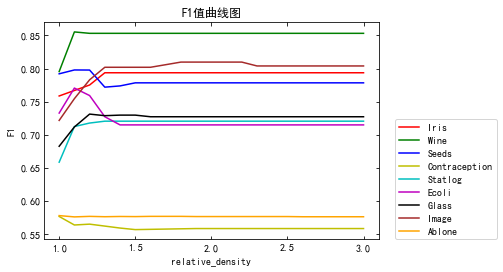

In [128]:
#%matplotlib
import matplotlib as mpl
import mpl_toolkits.axisartist.axislines as axislines
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False
fig = plt.figure()
ax1 = axislines.Subplot(fig, 1,1,1)
fig.add_subplot(ax1)
ax1.set_xticks([1,1.5,2,2.5,3])
re_density_value=list(np.arange(1,3.1,0.1))
plt.plot(re_density_value,iris_F1,'r-',label='Iris')
plt.plot(re_density_value,wine_F1,'g-',label='Wine')
plt.plot(re_density_value,seeds_F1,'b-',label='Seeds')
plt.plot(re_density_value,cmc_F1,'y-',label='Contraception')
plt.plot(re_density_value,statlog_F1,'c-',label='Statlog')
plt.plot(re_density_value,ecoli_F1,'m-',label='Ecoli')
plt.plot(re_density_value,glass_F1,'k-',label='Glass')
plt.plot(re_density_value,image_F1,'-',color='brown',label='Image')
plt.plot(re_density_value,ablone_F1,'-',color='orange',label='Ablone')
plt.xlabel('relative_density',fontsize=16)
plt.ylabel('F1',fontsize=16)
plt.title('F1值曲线图')
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0) #图例位置
plt.show()

In [129]:
Fsum=list(np.array(iris_F1)+np.array(wine_F1)+np.array(seeds_F1)+np.array(cmc_F1)+np.array(statlog_F1)+np.array(ecoli_F1)+np.array(glass_F1)+np.array(image_F1)+np.array(ablone_F1))

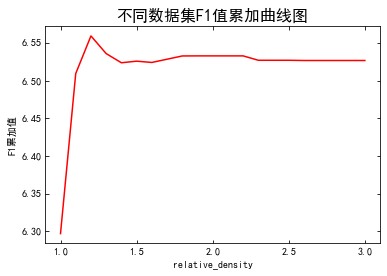

In [130]:
fig2 = plt.figure()
ax2 = axislines.Subplot(fig2, 1,1,1)
fig2.add_subplot(ax2)
ax2.set_xticks([1,1.5,2,2.5,3])
plt.plot(re_density_value,Fsum,'r-')
plt.xlabel('relative_density',fontsize=16)
plt.ylabel('F1累加值',fontsize=16)
plt.title('不同数据集F1值累加曲线图',fontsize=16)
plt.show()

In [131]:
re_density_value[Fsum.index(max(Fsum))]

1.2000000000000002